# Smart contract analysis
Analyse smart contracts from a MongoDB. To load data into MongoDB use the data-loader package.

In [22]:
import pymongo
from pprint import pprint

In [23]:
db = pymongo.MongoClient()

## Exploration

In [24]:
db.code.collection_names()

[u'code_base']

In [ ]:
pprint(
    db.code.code_base.find_one()
)

Display number of contracts in our collection

In [28]:
code_base = db.code.code_base
code_base.count()

2091

Display graph of code modification date.

In [29]:
from datetime import datetime
def convert_unixtime(timestamp):
    return datetime.utcfromtimestamp(timestamp)

In [45]:
timestamps = code_base.find({},{"date_modified":1, "_id":0})
time_list = []
for item in timestamps:
    time = convert_unixtime(item['date_modified'])
    time_list.append(time)
oldest = min(time_list)
youngest = max(time_list)
difference = youngest - oldest

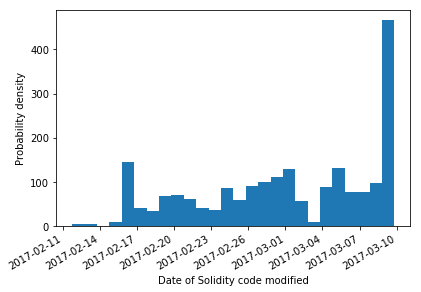

In [53]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
x = time_list
num_bins = difference.days
fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins)
ax.set_xlabel('Date of Solidity code modified')
ax.set_ylabel('Probability density')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
fig.autofmt_xdate()
plt.show()